In [1]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# get train data
# 초기상태에선 PIL(Python Imaging Library) 이미지 형식으로 Dataset을 만들어버린다
# 따라서 transform.ToTensor를 사용해 텐서로 변환한다
fashion_mnist_train = FashionMNIST('./FashionMNIST_train', train=True, download=True,
                                  transform=transforms.ToTensor())
fashion_mnist_test = FashionMNIST('./FashionMNIST_test', train=False, download=True,
                                 transform=transforms.ToTensor())

# batch size 128인 DataLoader를 각각 작성
batch_size = 128
train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=True)

Extracting ./FashionMNIST_train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST_train/FashionMNIST/raw


Extracting ./FashionMNIST_train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST_train/FashionMNIST/raw


Extracting ./FashionMNIST_train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST_train/FashionMNIST/raw


Extracting ./FashionMNIST_train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST_train/FashionMNIST/raw
Processing...
Done!



Extracting ./FashionMNIST_test/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST_test/FashionMNIST/raw


Extracting ./FashionMNIST_test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST_test/FashionMNIST/raw


Extracting ./FashionMNIST_test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST_test/FashionMNIST/raw


Extracting ./FashionMNIST_test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST_test/FashionMNIST/raw
Processing...
Done!


2층 합성곱과 2층 MLP를 연결한 CNN 작성

In [5]:
# (N, C, H, W) 형식의 텐서를 (N, C*H*W)로 늘리는 계층
# 합성곱 출력을 MLP에 전달할 때 필요
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

# 5x5 커널을 사용해서 처음에 32, 64개의 채널 작성
# BatchNorm2d는 이미지용 Batch Normalization
# Dropout2d는 이미지용 Dropout
# 마지막으로 FlattenLayer 적용

conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

# 합성곱에 의해 최종적으로 이미지 크기가 어떤지를 더미 데이터를 넣어 확인한다
test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]

# 2층 MLP
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)

# 최종 CNN
net = nn.Sequential(
    conv_net,
    mlp
)

평가와 훈련용 헬퍼 함수

In [8]:
# 평가용 헬퍼 함수
def eval_net(net, data_loader, device='cpu'):
    # Dropout 및 BatchNorm을 무효화
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        # to 메서드로 계산을 실행할 디바이스로 전송
        x = x.to(device)
        y = y.to(device)
        # 확률이 가장 큰 분류를 예측
        # 여기선 forward(추론) 계산이 전부이므로 자동 미분에 필요한 처리는 off로
        # 설정해서 불필요한 계산을 제한다
        with torch.no_grad():
            _, y_pred = net(x).max(1)
            ys.append(y)
            ypreds.append(y_pred)
    # 미니 배치 단위의 예측 결과 등을 하나로 묶는다
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 예측 정확도 계산
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

# 훈련용 헬퍼 함수
def train_net(net, train_loader, test_loader, optimizer_cls=optim.Adam,
             loss_fn=nn.CrossEntropyLoss(), n_iter=10, device='cpu'):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        # 신경망을 훈련 모드로 설정
        net.train()
        n = 0
        n_acc = 0
        # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
        for i, (xx, yy) in tqdm.tqdm(
            enumerate(train_loader), total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        # 훈련 데이터의 예측 정확도
        train_acc.append(n_acc / n)
        
        # 검증 데이터의 예측 정확도
        val_acc.append(eval_net(net, test_loader, device))
        # epoch의 결과 표시
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)

In [9]:
train_net(net, train_loader, test_loader, n_iter=20, device='cpu')

100%|██████████| 469/469 [00:50<00:00,  9.30it/s]


0 2.4893597756695542 0.09553333333333333 0.07100000232458115


100%|██████████| 469/469 [00:48<00:00,  9.63it/s]


1 2.485049108154753 0.0979 0.07209999859333038


100%|██████████| 469/469 [00:49<00:00,  9.46it/s]


2 2.4888202308589578 0.09458333333333334 0.0731000006198883


100%|██████████| 469/469 [00:48<00:00,  9.61it/s]


3 2.488373407950768 0.09431666666666666 0.07249999791383743


100%|██████████| 469/469 [00:49<00:00,  9.47it/s]


4 2.4875278890642347 0.0939 0.07000000029802322


100%|██████████| 469/469 [00:48<00:00,  9.61it/s]


5 2.4856340141377897 0.09468333333333333 0.07209999859333038


100%|██████████| 469/469 [00:47<00:00,  9.78it/s]


6 2.4866888054415712 0.09743333333333333 0.07199999690055847


100%|██████████| 469/469 [00:47<00:00,  9.93it/s]


7 2.49370682443309 0.09465 0.07240000367164612


100%|██████████| 469/469 [00:46<00:00, 10.18it/s]


8 2.4887209875970826 0.0957 0.07129999995231628


100%|██████████| 469/469 [00:47<00:00,  9.95it/s]


9 2.4880431834449115 0.09633333333333334 0.07190000265836716


100%|██████████| 469/469 [00:46<00:00, 10.06it/s]


10 2.4897939802235007 0.09366666666666666 0.07119999825954437


100%|██████████| 469/469 [00:47<00:00,  9.85it/s]


11 2.4884065593409743 0.09616666666666666 0.07209999859333038


100%|██████████| 469/469 [00:47<00:00,  9.84it/s]


12 2.4912179209228253 0.0938 0.07289999723434448


100%|██████████| 469/469 [00:47<00:00,  9.97it/s]


13 2.4855406778490443 0.09503333333333333 0.07090000063180923


100%|██████████| 469/469 [00:46<00:00, 10.16it/s]


14 2.4907604792179208 0.0936 0.07169999927282333


100%|██████████| 469/469 [00:46<00:00, 10.00it/s]


15 2.4883675396951856 0.09416666666666666 0.07209999859333038


100%|██████████| 469/469 [00:46<00:00, 10.05it/s]


16 2.487708622573787 0.09466666666666666 0.07320000231266022


100%|██████████| 469/469 [00:46<00:00, 10.02it/s]


17 2.487761338042398 0.09636666666666667 0.07270000129938126


100%|██████████| 469/469 [00:46<00:00,  9.99it/s]


18 2.4844685961038637 0.09641666666666666 0.07339999824762344


100%|██████████| 469/469 [00:46<00:00, 10.09it/s]


19 2.492772722346151 0.09465 0.07199999690055847


전이학습

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import tqdm

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# ImageFolder 함수를 사용해서 Dataset 작성
train_imgs = ImageFolder('/home/data/torch_test/taco_and_burrito/train',
                        transform=transforms.Compose([
                            transforms.RandomCrop(224),
                            transforms.ToTensor()
                        ]))
test_imgs = ImageFolder('/home/data/torch_test/taco_and_burrito/test/',
                       transform=transforms.Compose([
                           transforms.CenterCrop(224),
                           transforms.ToTensor()
                       ]))

# DataLoader 작성
train_loader = DataLoader(train_imgs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_imgs, batch_size=32, shuffle=False)

In [6]:
print(train_imgs.classes)

['burrito', 'taco']


In [7]:
print(train_imgs.class_to_idx)

{'burrito': 0, 'taco': 1}


In [8]:
from torchvision import models

# 사전 학습이 완료된 resnet18 불러오기
net = models.resnet18(pretrained=True)

# 모든 파라미터를 미분 대상에서 제외한다
for p in net.parameters():
    p.requires_grad=False

# 마지막 선형 계층을 변경한다
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

모델의 훈련 함수 작성

In [9]:
def eval_net(net, data_loader, device='cpu'):
    # Dropout 및 BatchNorm을 무효화
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        # to 메서드로 계산을 실행할 디바이스로 전송
        x = x.to(device)
        y = y.to(device)
        # 확률이 가장 큰 분류를 예측
        # 여기선 forward 계산이 전부이므로 자동 미분에 
        # 필요한 처리는 off로 설정해서 불필요한 계산을 제한다
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    
    # 미니 배치 단위의 예측 결과 등을 하나로 묶는다
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 예측 정확도 계산
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

def train_net(net, train_loader, test_loader, only_fc=True,
             optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(),
             n_iter=10, device='cpu'):
    train_losses = []
    train_acc = []
    val_acc = []
    if only_fc:
        # 마지막 선형 계층의 파라미터만 optimizer에 전달
        optimizer = optimizer_cls(net.fc.parameters())
    else:
        optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        # 신경망을 훈련모드로 설정
        net.train()
        n = 0
        n_acc = 0
        # 시간이 많이 걸리므로 tqdm을 사용해서 진행 바를 표시
        for i, (xx, yy) in tqdm.tqdm(
            enumerate(train_loader), total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        # 훈련 데이터의 예측 정확도
        train_acc.append(n_acc / n)
        
        # 검증 데이터의 예측 정확도
        val_acc.append(eval_net(net, test_loader, device))
        # epoch의 결과 표시
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
            

In [10]:
# 신경망의 모든 파라미터를 gpu로 전송
net.to('cuda:0')

# 훈련 실행
train_net(net, train_loader, test_loader, n_iter=20, device='cuda:0')

100%|██████████| 23/23 [00:45<00:00,  1.98s/it]


0 0.681564517996528 0.6348314606741573 0.8166667222976685


100%|██████████| 23/23 [00:45<00:00,  1.99s/it]


1 0.5297651101242412 0.776685393258427 0.8500000238418579


100%|██████████| 23/23 [00:44<00:00,  1.94s/it]


2 0.4623231359503486 0.8230337078651685 0.8666667342185974


100%|██████████| 23/23 [00:44<00:00,  1.94s/it]


3 0.4281188195401972 0.8328651685393258 0.8666667342185974


100%|██████████| 23/23 [00:46<00:00,  2.01s/it]


4 0.406482651152394 0.8314606741573034 0.8833333849906921


100%|██████████| 23/23 [00:45<00:00,  1.96s/it]


5 0.41249480030753394 0.824438202247191 0.8166667222976685


100%|██████████| 23/23 [00:45<00:00,  1.97s/it]


6 0.40103975615718146 0.8356741573033708 0.8500000238418579


100%|██████████| 23/23 [00:45<00:00,  1.96s/it]


7 0.3756311339410869 0.8441011235955056 0.8666667342185974


100%|██████████| 23/23 [00:43<00:00,  1.90s/it]


8 0.3614856011488221 0.8693820224719101 0.7833333611488342


100%|██████████| 23/23 [00:44<00:00,  1.94s/it]


9 0.35820556432008743 0.8426966292134831 0.7833333611488342


100%|██████████| 23/23 [00:44<00:00,  1.94s/it]


10 0.33723823116584256 0.8595505617977528 0.8666667342185974


100%|██████████| 23/23 [00:45<00:00,  1.96s/it]


11 0.31587143343957985 0.8651685393258427 0.8666667342185974


100%|██████████| 23/23 [00:45<00:00,  1.97s/it]


12 0.33000037141821603 0.875 0.8666667342185974


100%|██████████| 23/23 [00:45<00:00,  1.99s/it]


13 0.29164937003092334 0.8764044943820225 0.8666667342185974


100%|██████████| 23/23 [00:45<00:00,  2.00s/it]


14 0.3153148645704443 0.8764044943820225 0.8666667342185974


100%|██████████| 23/23 [00:45<00:00,  1.98s/it]


15 0.3141983137889342 0.875 0.8833333849906921


100%|██████████| 23/23 [00:44<00:00,  1.92s/it]


16 0.3537514351985671 0.8469101123595506 0.8666667342185974


100%|██████████| 23/23 [00:45<00:00,  1.97s/it]


17 0.36047401414676145 0.8412921348314607 0.8333333730697632


100%|██████████| 23/23 [00:44<00:00,  1.92s/it]


18 0.31013350866057654 0.8890449438202247 0.8666667342185974


100%|██████████| 23/23 [00:43<00:00,  1.88s/it]


19 0.2815042957663536 0.8876404494382022 0.8666667342185974


이미지 해상도 향상

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [4]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, 
                 large_size=128, small_size=32, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        
        # 읽은 이미지를 128 x 128 픽셀과 32 x 32 픽셀로 리사이즈
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        
        # 기타 변환 적용
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
            
        # 32 픽셀의 이미지와 128 픽셀의 이미지 반환
        return small_img, large_img

In [7]:
train_data = DownSizedPairImageFolder(
'/home/data/torch_test/lfw-deepfunneled/train', transform=transforms.ToTensor())
test_data = DownSizedPairImageFolder(
'/home/data/torch_test/lfw-deepfunneled/test', transform=transforms.ToTensor())

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [10]:
net = nn.Sequential(
    nn.Conv2d(3, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
)

PSNR 계산

In [15]:
import math

def psnr(mse, max_v=1.0):
    return 10 * math.log10(max_v**2 / mse)

# 평가 헬퍼 함수
def eval_net(net, data_loader, device='cpu'):
    # Dropout 및 BatchNorm을 무효화
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_pred = net(x)
        ys.append(y)
        ypreds.append(y_pred)
        
    # 미니 배치 단위로 예측 결과 등을 하나로 모은다
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 예측 정확도(MSE) 계산
    score = nn.functional.mse_loss(ypreds, ys).item()
    return score

# 훈련 헬퍼 함수
def train_net(net, train_loader, test_loader, optimizer_cls=optim.Adam,
             loss_fn=nn.MSELoss(), n_iter=10, device='cpu'):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        # 신경망을 훈련 모드로 설정
        net.train()
        n = 0
        score = 0
        
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            y_pred = net(xx)
            loss = loss_fn(y_pred, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
        train_losses.append(running_loss / len(train_loader))
        # 검증 데이터의 훈련 정확도
        val_acc.append(eval_net(net, test_loader, device))
        # epoch의 결과 표시
        print(epoch, train_losses[-1], psnr(train_losses[-1]), psnr(val_acc[-1]), flush=True)

In [16]:
net.to('cuda:0')
train_net(net, train_loader, test_loader, device='cuda:0')

100%|██████████| 409/409 [00:09<00:00, 45.21it/s]


0 0.006701648936659316 21.738183262567894 24.740722808667744


100%|██████████| 409/409 [00:08<00:00, 46.11it/s]


1 0.003375598703668177 24.716491885693358 25.115221487793473


100%|██████████| 409/409 [00:08<00:00, 45.98it/s]


2 0.002933728673169731 25.325800544988873 25.44065500859102


100%|██████████| 409/409 [00:08<00:00, 45.45it/s]


3 0.002657963281490528 25.75451022925339 26.669806085100216


100%|██████████| 409/409 [00:08<00:00, 45.81it/s]


4 0.002508218901705516 26.006345636729794 26.384431637715863


100%|██████████| 409/409 [00:08<00:00, 45.68it/s]


5 0.0024034165595669507 26.191709508595174 25.653947788045866


100%|██████████| 409/409 [00:08<00:00, 45.63it/s]


6 0.0022864542482534654 26.40837484390385 25.83584512879628


100%|██████████| 409/409 [00:09<00:00, 44.66it/s]


7 0.002287896317293216 26.405636607565114 27.021832583396744


100%|██████████| 409/409 [00:08<00:00, 45.76it/s]


8 0.00221671005807735 26.542911081537994 27.33180793803147


100%|██████████| 409/409 [00:08<00:00, 45.85it/s]


9 0.0021849415549088477 26.60560175499077 26.929917701653842


In [17]:
from torchvision.utils import save_image

# 테스트 데이터로부터 랜덤으로 4개씩 추출하는 DataLoader
random_test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
# DataLoader를 파이썬의 이터레이터로 변환해서 4개의 예로 추출
it = iter(random_test_loader)
x, y = next(it)

# Bilinear를 사용한 확대
bl_recon = torch.nn.functional.upsample(x, 128, mode='bilinear', align_corners=True)
# CNN으로 확대
yp = net(x.to('cuda:0')).to('cpu')

# torch.cat로 원본, Bilinear,CNN 이미지를 결합하고 save_image로 결합한 이미지를 출력
save_image(torch.cat([y, bl_recon, yp], 0), 'cnn_upscale.jpg', nrow=4)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


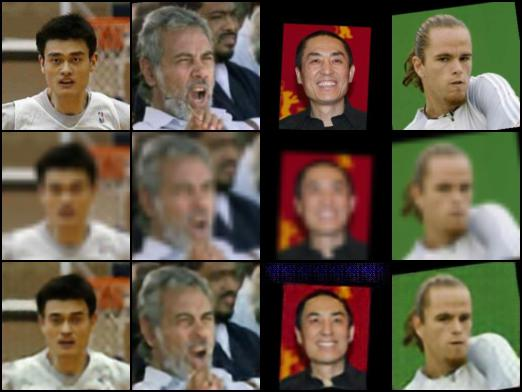

In [18]:
from IPython.display import Image, display_jpeg
display_jpeg(Image('cnn_upscale.jpg'))